# 8. Daily Inference Pipeline
Generate predictions for the next trading day

In [9]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from utils.hopsworks_helpers import get_feature_store, get_model_registry, create_feature_group
import joblib
import yaml

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## Load Models from Registry

In [10]:
"""
mr = get_model_registry()

# Get latest model versions
regressor_model = mr.get_model("qqq_return_regressor", version=1)
classifier_model = mr.get_model("qqq_direction_classifier", version=1)

# Download and load models
regressor_path = regressor_model.download()
classifier_path = classifier_model.download()

regressor = joblib.load(regressor_path)
classifier = joblib.load(classifier_path)

print("Models loaded from Hopsworks Model Registry")
"""

'\nmr = get_model_registry()\n\n# Get latest model versions\nregressor_model = mr.get_model("qqq_return_regressor", version=1)\nclassifier_model = mr.get_model("qqq_direction_classifier", version=1)\n\n# Download and load models\nregressor_path = regressor_model.download()\nclassifier_path = classifier_model.download()\n\nregressor = joblib.load(regressor_path)\nclassifier = joblib.load(classifier_path)\n\nprint("Models loaded from Hopsworks Model Registry")\n'

## Get Latest Features

In [11]:
import joblib

# Percorsi corretti dei modelli salvati localmente
regressor_path = "../models/qqq_regressor.pkl"
classifier_path = "../models/qqq_classifier.pkl"

# Carica i modelli
regressor = joblib.load(regressor_path)
classifier = joblib.load(classifier_path)

print("Models loaded successfully!")

Models loaded successfully!


In [12]:
fs = get_feature_store()
feature_view = fs.get_feature_view('qqq_prediction_fv', version=1)

# Get batch data (latest features)
batch_data = feature_view.get_batch_data()

# Get the most recent row (latest trading day)
latest_features = batch_data.tail(1)

print(f"Latest feature date: {latest_features.index[0] if hasattr(latest_features.index[0], 'date') else 'N/A'}")
print(f"Features shape: {latest_features.shape}")
latest_features.head()

2026-01-05 20:22:27,730 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 20:22:27,733 INFO: Initializing external client
2026-01-05 20:22:27,734 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 20:22:29,094 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 
Latest feature date: N/A
Features shape: (1, 34)


,date,return_1d,return_2d,return_3d,return_5d,volatility_5d,volatility_10d,volatility_20d,rsi_14,ma_ratio_10,...,dgs10_chg_5d,dgs10_chg_20d,cpi_level_asof,cpi_yoy_asof,sentiment_mean,sentiment_std,article_count,positive_mean,negative_mean,neutral_mean
1130,2021-05-24 00:00:00+00:00,-0.1669,0.45984,0.17679,0.150736,0.424484,0.315812,0.27575,52.369857,1.020622,...,-0.03,0.03,266.625,4.137373,0.0,0.0,0.0,0.0,0.0,0.0


## Generate Predictions

In [16]:
# Remove target columns if present
#feature_cols = [col for col in latest_features.columns if not col.startswith('target_')]
#X_latest = latest_features[feature_cols]

feature_cols = [col for col in latest_features.columns if not col.startswith('target_') and col != 'date']
X_latest = latest_features[feature_cols]

# Colonne effettivamente usate dal modello
model_features = [
    'return_1d', 'return_2d', 'return_3d', 'return_5d',
    'volatility_5d', 'volatility_10d', 'volatility_20d',
    'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50',
    'return_1d_xlk', 'return_5d_xlk', 'corr_20d', 'corr_60d',
    'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20',
    'vix_std_20', 'vix_ma_ratio', 'dgs10', 'dgs10_chg_1d',
    'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof',
    'positive_mean', 'negative_mean', 'neutral_mean'
]

# Seleziona solo le colonne che il modello si aspetta
X_latest_model = X_latest[model_features]
# Regression prediction (return)
predicted_return = regressor.predict(X_latest_model)[0]

# Classification prediction (direction)
predicted_direction = classifier.predict(X_latest_model)[0]
predicted_proba = classifier.predict_proba(X_latest_model)[0, 1]  # Probability of UP

"""
# Regression prediction (return)
predicted_return = regressor.predict(X_latest)[0]

# Classification prediction (direction)
predicted_direction = classifier.predict(X_latest)[0]
predicted_proba = classifier.predict_proba(X_latest)[0, 1]  # Probability of up
"""

print(f"\n===== PREDICTIONS FOR NEXT TRADING DAY =====")
print(f"Predicted Return: {predicted_return:.4f} ({predicted_return*100:.2f}%)")
print(f"Predicted Direction: {'UP' if predicted_direction == 1 else 'DOWN'}")
print(f"Probability of UP: {predicted_proba:.4f} ({predicted_proba*100:.1f}%)")
print(f"Probability of DOWN: {1-predicted_proba:.4f} ({(1-predicted_proba)*100:.1f}%)")


===== PREDICTIONS FOR NEXT TRADING DAY =====
Predicted Return: 0.0002 (0.02%)
Predicted Direction: UP
Probability of UP: 0.5109 (51.1%)
Probability of DOWN: 0.4891 (48.9%)


## Feature Importance for This Prediction


Top 10 Features Driving This Prediction:
       feature  importance     value
  cpi_yoy_asof    0.074252  4.137373
  dgs10_chg_5d    0.069449 -0.030000
  vix_ma_ratio    0.066111  0.880636
volatility_10d    0.065863  0.315812
    vix_change    0.063178  2.960000
 dgs10_chg_20d    0.057835  0.030000
volatility_20d    0.056760  0.275750
     return_5d    0.052646  0.150736
   ma_ratio_50    0.049240  1.055438
     return_2d    0.049195  0.459840


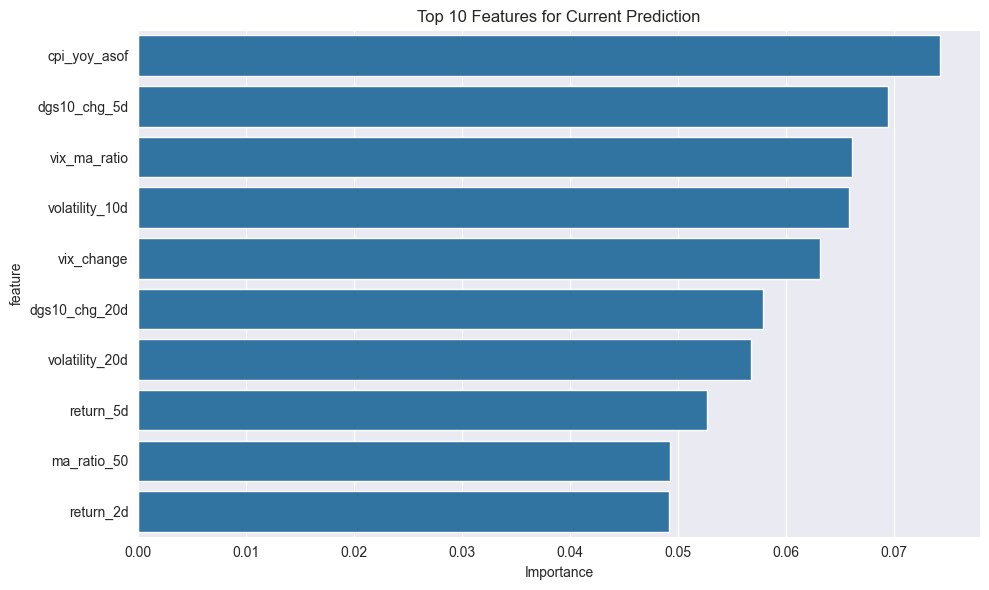

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

"""
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': regressor.feature_importances_,
    'value': X_latest.values[0]
}).sort_values('importance', ascending=False)

# Show top 10 features driving this prediction
print("\nTop 10 Features Driving This Prediction:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features for Current Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
"""

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assicurati di usare le colonne corrette
feature_importance = pd.DataFrame({
    'feature': X_latest_model.columns,               # colonne effettive del modello
    'importance': regressor.feature_importances_,   # importanza dal modello
    'value': X_latest_model.values[0]               # valori corrispondenti
}).sort_values('importance', ascending=False)

# Top 10
print("\nTop 10 Features Driving This Prediction:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Features for Current Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Save Predictions

In [21]:
# Create prediction record
prediction_date = datetime.now().strftime('%Y-%m-%d')

prediction_record = pd.DataFrame([{
    'prediction_date': prediction_date,
    'predicted_return': predicted_return,
    'predicted_direction': predicted_direction,
    'predicted_proba_up': predicted_proba,
    'model_version_regressor': 1,
    'model_version_classifier': 1
}])

# Add top 5 feature values
for idx, row in feature_importance.head(5).iterrows():
    prediction_record[f'feature_{row["feature"]}'] = row['value']

prediction_record

,prediction_date,predicted_return,predicted_direction,predicted_proba_up,model_version_regressor,model_version_classifier,feature_cpi_yoy_asof,feature_dgs10_chg_5d,feature_vix_ma_ratio,feature_volatility_10d,feature_vix_change
0,2026-01-05,0.000167,1,0.510875,1,1,4.137373,-0.03,0.880636,0.315812,2.96


In [25]:
# Save to Hopsworks as a feature group (for dashboard)
"""
predictions_fg = create_feature_group(
    fs,
    name='qqq_predictions',
    df=prediction_record,
    primary_key=['prediction_date'],
    description='Daily QQQ predictions with model outputs and key features'
)

print(f"\nPrediction saved to Hopsworks for {prediction_date}")
"""
from hsfs.feature_group import FeatureGroup

import pandas as pd

# Assicurati che la colonna prediction_date sia datetime
prediction_record['prediction_date'] = pd.to_datetime(prediction_record['prediction_date'])

# 1️⃣ Crea il feature group
predictions_fg = fs.create_feature_group(
    name='qqq_predictions',
    version=1,
    description='Daily QQQ predictions with model outputs and key features',
    primary_key=['prediction_date'],  # chiave primaria
    event_time='prediction_date'      # colonna timestamp
)

# 2️⃣ Inserisci i dati
predictions_fg.insert(prediction_record, write_options={"wait_for_job": True})

print(f"\nPrediction saved to Hopsworks for {prediction_record['prediction_date'].iloc[0]}")

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272010/fs/1258611/fg/1893814


Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: qqq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/qqq_predictions_1_offline_fg_materialization/executions
2026-01-05 20:31:14,448 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-05 20:31:17,653 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2026-01-05 20:31:20,894 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-05 20:33:13,528 INFO: Waiting for log aggregation to finish.
2026-01-05 20:33:32,526 INFO: Execution finished successfully.

Prediction saved to Hopsworks for 2026-01-05 00:00:00


## Historical Prediction Performance (Optional)

2026-01-05 20:47:57,795 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-05 20:47:57,797 INFO: Initializing external client
2026-01-05 20:47:57,797 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 20:47:59,095 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1272010/fs/1258611/fv/qqq_prediction_target/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.38s) 


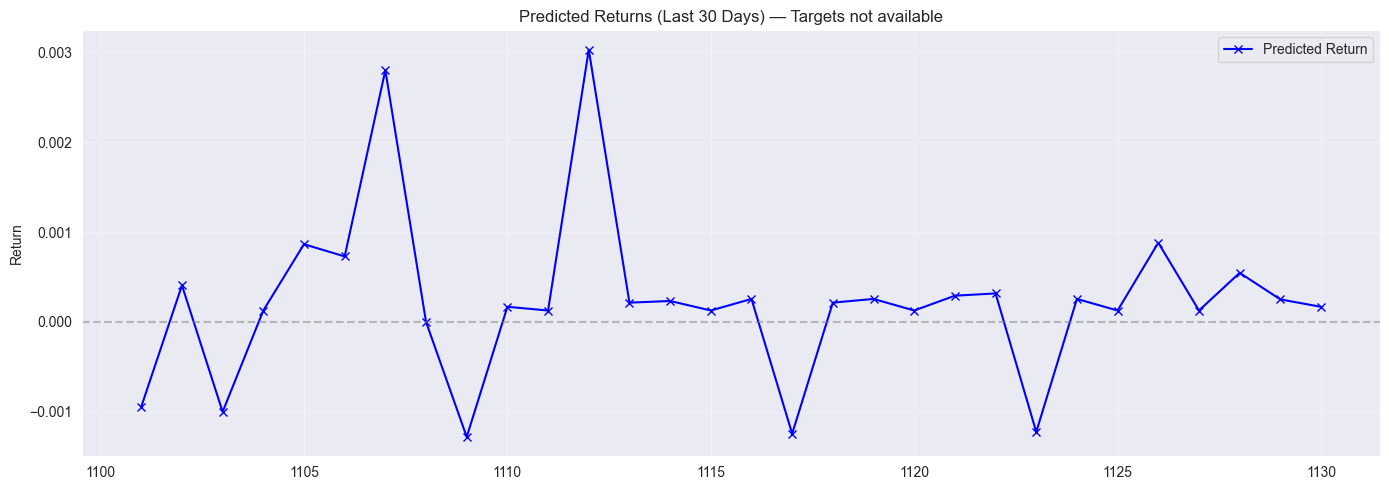

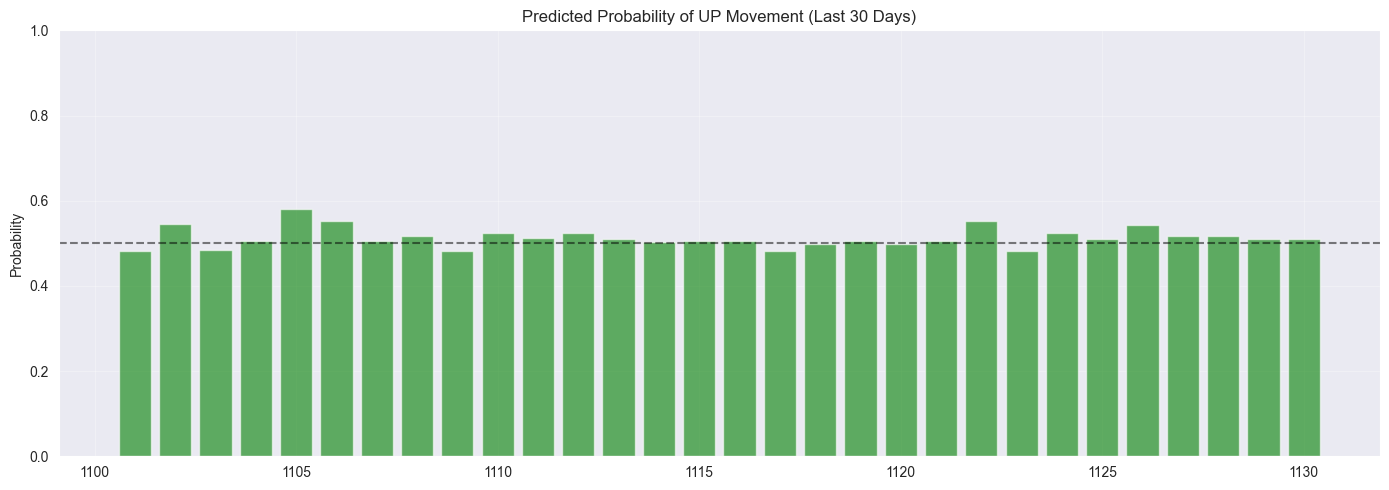

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Connetti al Feature Store ---
fs = get_feature_store()

# --- 2️⃣ Definisci le feature usate in training ---
feature_names = [
    'return_1d', 'return_2d', 'return_3d', 'return_5d',
    'volatility_5d', 'volatility_10d', 'volatility_20d',
    'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50',
    'return_1d_xlk', 'return_5d_xlk', 'corr_20d', 'corr_60d',
    'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20',
    'vix_std_20', 'vix_ma_ratio', 'dgs10', 'dgs10_chg_1d',
    'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof',
    'positive_mean', 'negative_mean', 'neutral_mean'
]

# --- 3️⃣ Crea la Feature View con target ---
query = fs.get_feature_group('qqq_combined_features', version=1).select(
    ['date'] + feature_names + ['target_return', 'target_direction']
)

feature_view = fs.create_feature_view(
    name='qqq_prediction_target',
    version=1,
    query=query,
    labels=['target_return', 'target_direction']
)

# --- 4️⃣ Recupera batch data ---
batch_data = feature_view.get_batch_data()

# --- 5️⃣ Seleziona ultimi 30 giorni e le colonne usate in training ---
recent_data = batch_data.tail(30)
X_recent = recent_data[feature_names]

# --- 6️⃣ Prendi i target se presenti ---
y_recent_return = recent_data['target_return'] if 'target_return' in recent_data.columns else None
y_recent_direction = recent_data['target_direction'] if 'target_direction' in recent_data.columns else None

# --- 7️⃣ Predizioni ---
pred_returns = regressor.predict(X_recent)
pred_directions = classifier.predict(X_recent)
pred_probas = classifier.predict_proba(X_recent)[:, 1]  # probability of UP

# --- 8️⃣ Crea DataFrame per visualizzazione ---
viz_df = pd.DataFrame({
    'predicted_return': pred_returns,
    'predicted_direction': pred_directions,
    'predicted_proba': pred_probas
}, index=recent_data.index)

targets_available = False
if y_recent_return is not None and y_recent_direction is not None:
    viz_df['actual_return'] = y_recent_return.values
    viz_df['actual_direction'] = y_recent_direction.values
    targets_available = True

# --- 9️⃣ Plot returns ---
fig, ax = plt.subplots(figsize=(14, 5))
if targets_available:
    ax.plot(viz_df.index, viz_df['actual_return'], label='Actual Return', marker='o')
    ax.plot(viz_df.index, viz_df['predicted_return'], label='Predicted Return', marker='x')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Predicted vs Actual Returns (Last 30 Days)')
    ax.set_ylabel('Return')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Calcola accuracy direzionale
    accuracy = (viz_df['predicted_direction'] == viz_df['actual_direction']).mean()
    print(f"\nDirectional Accuracy (Last 30 Days): {accuracy:.2%}")
else:
    ax.plot(viz_df.index, viz_df['predicted_return'], label='Predicted Return', marker='x', color='blue')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Predicted Returns (Last 30 Days) — Targets not available')
    ax.set_ylabel('Return')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# --- 10️⃣ Plot probabilità direzione ---
fig, ax2 = plt.subplots(figsize=(14, 5))
colors = ['green' if d == 1 else 'red' for d in
          (viz_df['actual_direction'] if targets_available else [1] * len(viz_df))]
ax2.bar(viz_df.index, viz_df['predicted_proba'], color=colors, alpha=0.6)
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Predicted Probability of UP Movement (Last 30 Days)')
ax2.set_ylabel('Probability')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

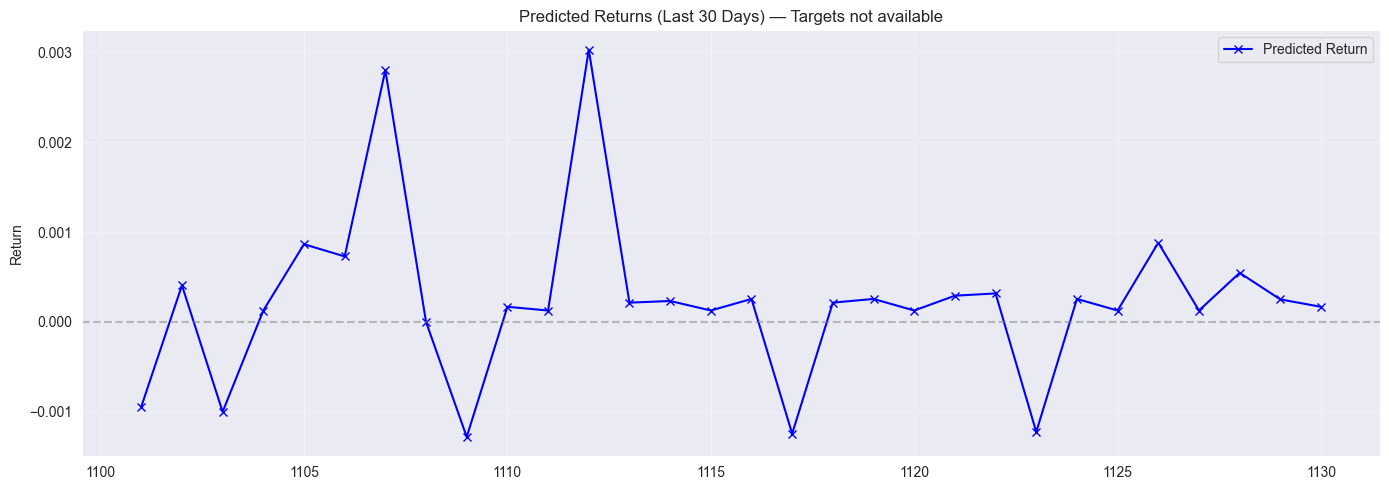

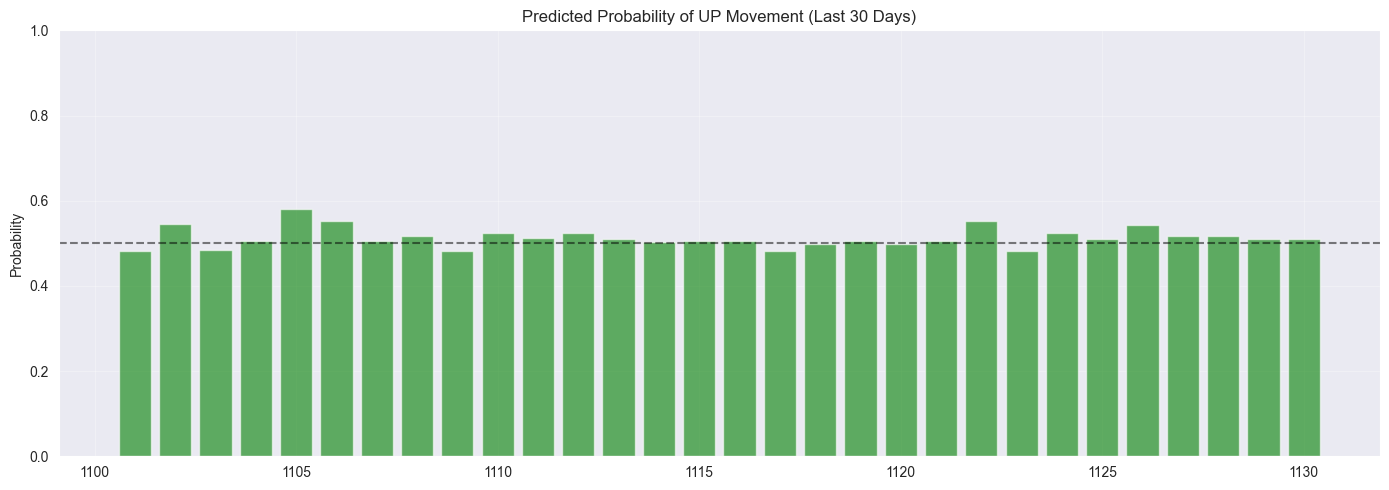

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Colonne usate in training ---
model_features = [
    'return_1d', 'return_2d', 'return_3d', 'return_5d',
    'volatility_5d', 'volatility_10d', 'volatility_20d',
    'rsi_14', 'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50',
    'return_1d_xlk', 'return_5d_xlk', 'corr_20d', 'corr_60d',
    'vix_close', 'vix_change', 'vix_pct_change', 'vix_ma_20',
    'vix_std_20', 'vix_ma_ratio', 'dgs10', 'dgs10_chg_1d',
    'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof', 'cpi_yoy_asof',
    'positive_mean', 'negative_mean', 'neutral_mean'
]

# --- Seleziona ultimi 30 giorni ---
recent_data = batch_data.tail(30)

# Rimuovi target e colonne non usate
X_recent = recent_data[[col for col in recent_data.columns if col in model_features]]

# Prendi target se disponibili
y_recent_return = recent_data['target_return'] if 'target_return' in recent_data.columns else None
y_recent_direction = recent_data['target_direction'] if 'target_direction' in recent_data.columns else None

# --- Predizioni ---
pred_returns = regressor.predict(X_recent)
pred_directions = classifier.predict(X_recent)
pred_probas = classifier.predict_proba(X_recent)[:, 1]  # probability of UP

# --- Crea DataFrame per visualizzazione ---
viz_df = pd.DataFrame({
    'predicted_return': pred_returns,
    'predicted_direction': pred_directions,
    'predicted_proba': pred_probas
}, index=recent_data.index)

if y_recent_return is not None and y_recent_direction is not None:
    viz_df['actual_return'] = y_recent_return.values
    viz_df['actual_direction'] = y_recent_direction.values
    targets_available = True
else:
    targets_available = False

# --- Plot ---
fig, ax = plt.subplots(figsize=(14,5))

if targets_available:
    # Plot return predicted vs actual
    ax.plot(viz_df.index, viz_df['actual_return'], label='Actual Return', marker='o')
    ax.plot(viz_df.index, viz_df['predicted_return'], label='Predicted Return', marker='x')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Predicted vs Actual Returns (Last 30 Days)')
    ax.set_ylabel('Return')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Calcola accuracy direzionale
    accuracy = (viz_df['predicted_direction'] == viz_df['actual_direction']).mean()
    print(f"\nDirectional Accuracy (Last 30 Days): {accuracy:.2%}")

else:
    # Plot solo predicted return
    ax.plot(viz_df.index, viz_df['predicted_return'], label='Predicted Return', marker='x', color='blue')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_title('Predicted Returns (Last 30 Days) — Targets not available')
    ax.set_ylabel('Return')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# --- Plot probabilità direzione ---
fig, ax2 = plt.subplots(figsize=(14,5))
colors = ['green' if d == 1 else 'red' for d in (viz_df['actual_direction'] if targets_available else [1]*len(viz_df))]
ax2.bar(viz_df.index, viz_df['predicted_proba'], color=colors, alpha=0.6)
ax2.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Predicted Probability of UP Movement (Last 30 Days)')
ax2.set_ylabel('Probability')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
print(batch_data.columns)

Index(['date', 'return_1d', 'return_2d', 'return_3d', 'return_5d',
       'volatility_5d', 'volatility_10d', 'volatility_20d', 'rsi_14',
       'ma_ratio_10', 'ma_ratio_20', 'ma_ratio_50', 'return_1d_xlk',
       'return_5d_xlk', 'corr_20d', 'corr_60d', 'vix_close', 'vix_change',
       'vix_pct_change', 'vix_ma_20', 'vix_std_20', 'vix_ma_ratio', 'dgs10',
       'dgs10_chg_1d', 'dgs10_chg_5d', 'dgs10_chg_20d', 'cpi_level_asof',
       'cpi_yoy_asof', 'sentiment_mean', 'sentiment_std', 'article_count',
       'positive_mean', 'negative_mean', 'neutral_mean'],
      dtype='object')
